# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

### Load Data

In [2]:
# Read dataset
df = pd.read_csv('superstore.csv')
df.head(3)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


## Data Handling

In [3]:
# Check missing value

df.isna().sum()

row_id           0
order_id         0
order_date       0
ship_date        0
ship_mode        0
customer_id      0
customer_name    0
segment          0
country          0
city             0
state            0
postal_code      0
region           0
product_id       0
category         0
sub_category     0
product_name     0
sales            0
quantity         0
discount         0
profit           0
dtype: int64

In [4]:
# Checking duplicated rows

df.duplicated().sum()

0

In [5]:
# Convert type columns order date and ship date to type datetime
df ['order_date'] = pd.to_datetime(df['order_date'])
df ['ship_date'] = pd.to_datetime(df['ship_date'])

# Create a new column for Shipping time
df['shipping_time'] = df['ship_date'] - df['order_date']

# Convert dtype timedelta to numerik of days
df ['shipping_time'] = df['shipping_time'].dt.days

# Remove Unecessary Column
df.drop(['row_id', 'order_id', 'order_date', 'ship_date',
         'customer_id', 'postal_code', 'product_id', 'customer_id'], axis=1)

# Group column names based on type
cats = ['ship_mode', 'customer_name', 'segment', 'country', 'city', 'state', 'region',
        'category', 'sub_category', 'product_name']
nums = ['sales', 'quantity', 'discount', 'profit', 'shipping_time']

## Statistical Summary

In [6]:
# Numerical statistical summary
df[nums].describe()

,sales,quantity,discount,profit,shipping_time
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,3.789574,0.156203,28.656896,3.958175
std,623.245101,2.225110,0.206452,234.260108,1.747567
min,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,17.280000,2.000000,0.000000,1.728750,3.000000
50%,54.490000,3.000000,0.200000,8.666500,4.000000
75%,209.940000,5.000000,0.200000,29.364000,5.000000
max,22638.480000,14.000000,0.800000,8399.976000,7.000000


Observation :
* `sales` showing  a positively skewed of data distribution. it means there are very a big difference. with minimum value 0.4, maksmimum value 22,638 and mean 230
* `quantity` in table showing average buys ~3 items for each order and mean of `discount` is 15% with average of `profit`earned 29 dollar for each order

In [7]:
# Categorical summary
df[cats].describe()

,ship_mode,customer_name,segment,country,city,state,region,category,sub_category,product_name
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994
unique,4,793,3,1,531,49,4,3,17,1850
top,Standard Class,William Brown,Consumer,United States,New York City,California,West,Office Supplies,Binders,Staple envelope
freq,5968,37,5191,9994,915,2001,3203,6026,1523,48


Observation:
* all column has a 9994 rows
* based on `order_date`, the most transactions occured on 9/05/2016 with 38 transaction for a day 
* `ship_date` is date of item when the order arrived
* `ship_mode` have a 4 shipping type with 5.968 customers used a Standard Class shipping
* `customer_name` have a 793 name, William Brown is who often shop with 37x freq
* in a `segment` that have a 3 unique type customer
* `country` just United States, with 531 `city`, and 49 `state` in 4 `region` different
* `product_id` is label of each item
* have a 3 `category` with the most of sold is Office Supplies
* have a 17  `sub_category` and the most of sold is Binder with 1.523x freq
* in `product_name` have a 1.850 items

## Multicollinearity Check

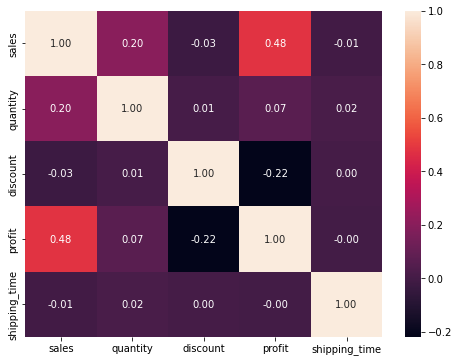

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df[nums].corr(), annot=True, fmt='.2f')
plt.show()

Observation :
* No need to drop!

## Univariate Analysis

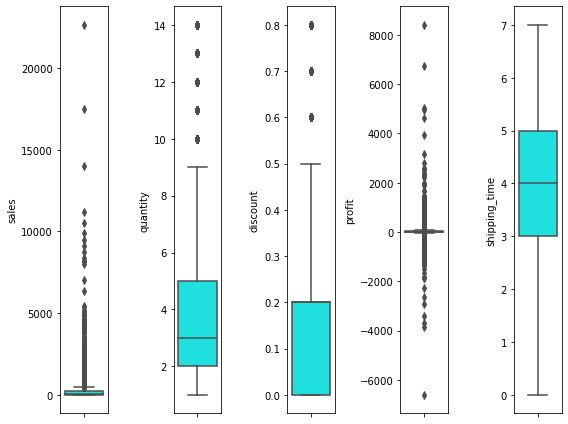

In [9]:
# adjust the figure size for better readability
plt.figure(figsize=(8,6))
# plotting
features = nums
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='cyan')
    plt.tight_layout()


plt.show()

In [10]:
# Remove Outlier
outl = df[['sales','quantity','discount','profit']]
outl.head()

,sales,quantity,discount,profit
0,261.9600,2,0.00,41.9136
1,731.9400,3,0.00,219.5820
2,14.6200,2,0.00,6.8714
3,957.5775,5,0.45,-383.0310
4,22.3680,2,0.20,2.5164


In [11]:
fit_df1, fit_lambda = stats.boxcox(outl['sales'])
df['sales']=fit_df1
fit_df2, fit_lambda = stats.boxcox(outl['quantity'])
df['quantity']=fit_df2

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

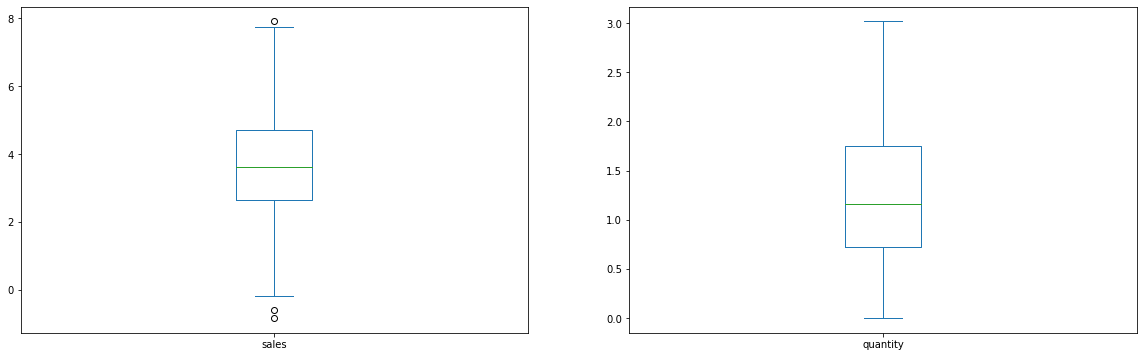

In [12]:
plt.figure(1)
plt.figure(figsize = (20, 6))
plt.subplot(121)
df['sales'].plot(kind='box')
plt.subplot(122)
df['quantity'].plot(kind='box')

## Check Distribution Target

<AxesSubplot:xlabel='shipping_time', ylabel='Count'>

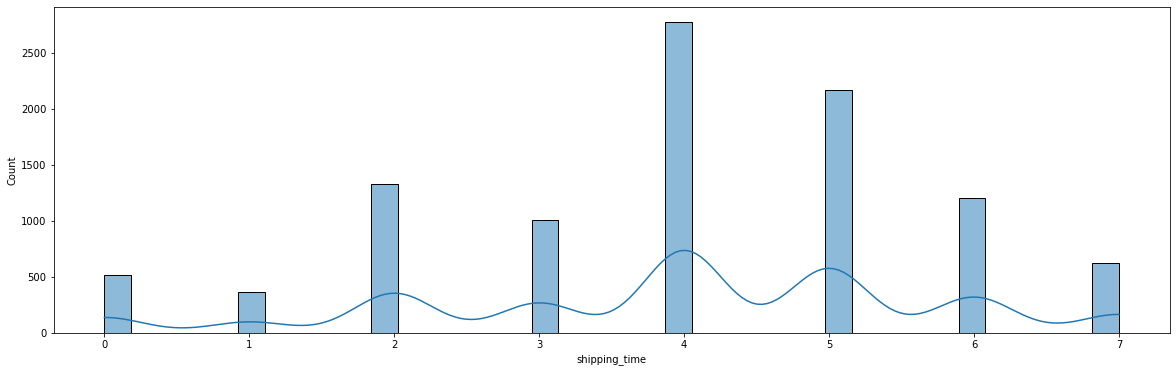

In [13]:
plt.figure(figsize = (20, 6))
#df['shipping_time'].hist(bins = n_bins)
sns.histplot(data=df, x="shipping_time", kde=True)

Note:
* Most shipping times on the 4th day


<AxesSubplot:xlabel='shipping_time', ylabel='count'>

<Figure size 432x288 with 0 Axes>

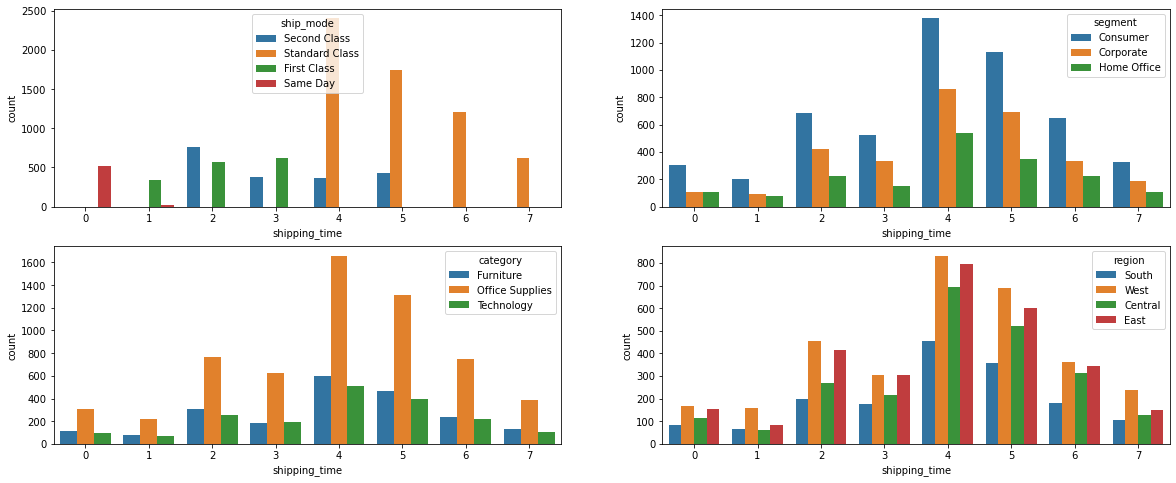

In [14]:
plt.figure(1)
plt.figure(figsize=(20,8))

# segment affect ship_mode
plt.subplot(221)
sns.countplot(data=df, x='shipping_time',
              hue = 'ship_mode')

# segment affect segment
plt.subplot(222)
sns.countplot(data=df, x='shipping_time',
              hue = 'segment')

# segment affect category
plt.subplot(223)
sns.countplot(data=df, x='shipping_time',
              hue = 'category')

# segment affect region
plt.subplot(224)
sns.countplot(data=df, x='shipping_time',
              hue = 'region')



Note: 
* Shipping time for Standar class around 4-7 day
* Segment Consumer dominate on day 4
* Office supplies is mostly sold in all segments
* West Region orders more goods and used a Standar class ship mode

<Figure size 432x288 with 0 Axes>

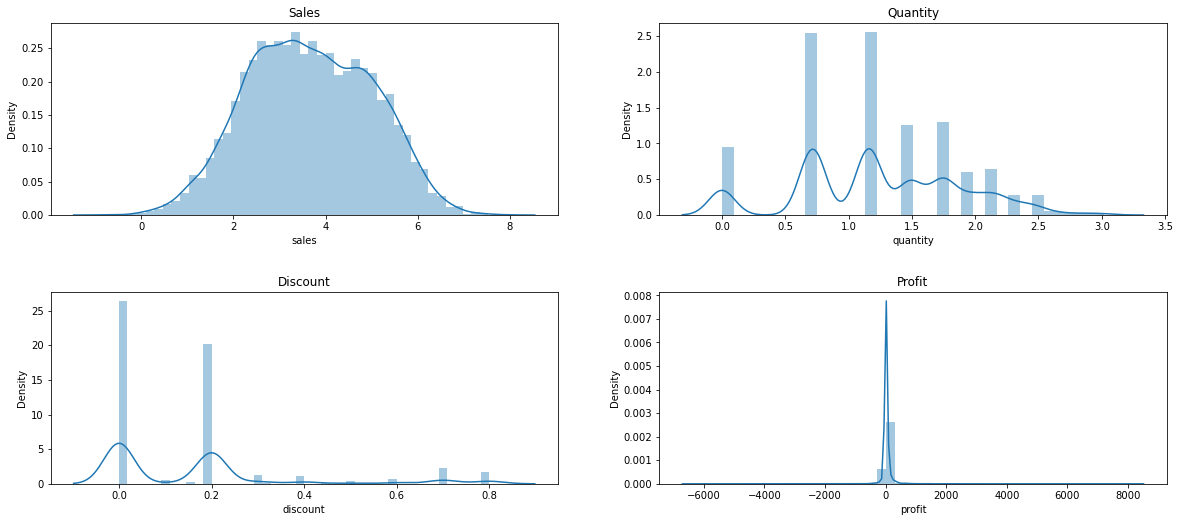

In [15]:
# Number Columns

plt.figure(1)
plt.figure(figsize=(20,8))
plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)

# Column (Sales)
plt.subplot(221)
sns.distplot(df['sales'])
plt.title('Sales')

# Column (Quantity)
plt.subplot(222)
sns.distplot(df['quantity'])
plt.title('Quantity')

# Column (Discount)
plt.subplot(223)
sns.distplot(df['discount'])
plt.title('Discount')

# Column (Discount)
plt.subplot(224)
sns.distplot(df['profit'])
plt.title('Profit')
plt.show()

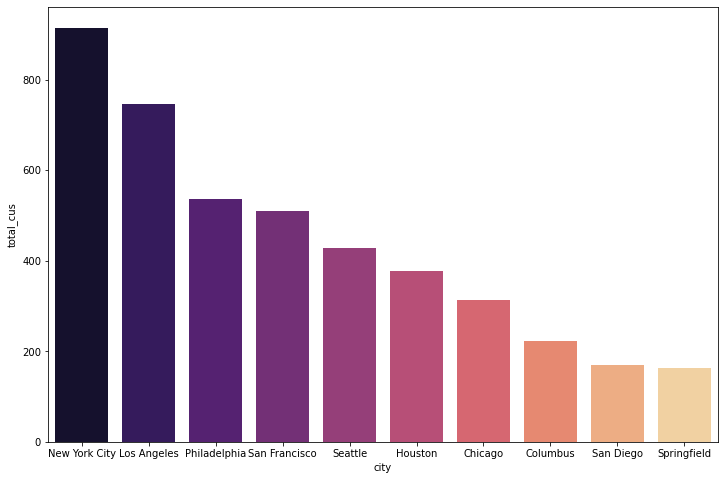

In [16]:
a = (df.groupby('city')
     .agg(total_cus=('customer_name', 'count'))
     .sort_values('total_cus', ascending=0)
     .head(10)
     .reset_index())

# Visualize 
plt.figure(figsize=(12,8))
sns.barplot(data=a, x='city', y='total_cus', palette='magma')
plt.show()

Note:
* New York City is the most order of goods

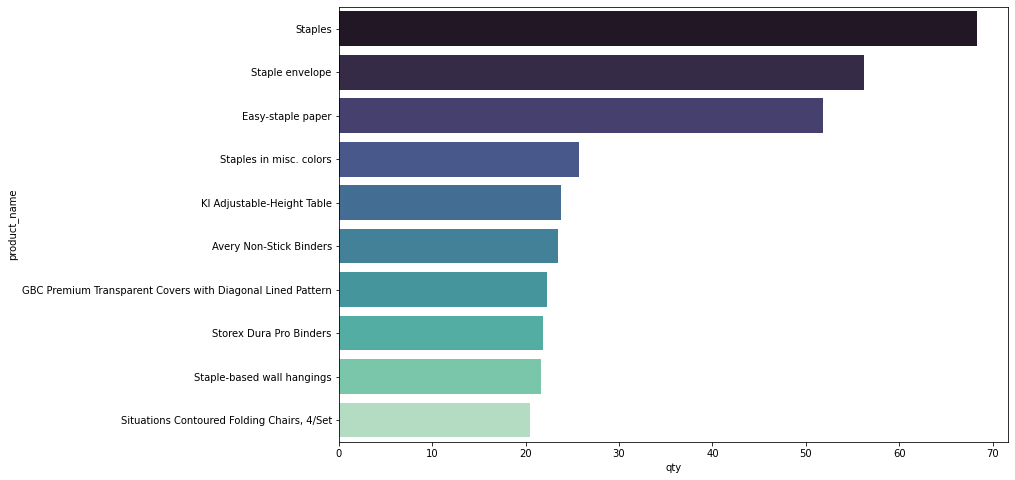

In [17]:
b = (df.groupby('product_name')
       .agg(qty=('quantity', 'sum'))
       .reset_index()
       .sort_values('qty', ascending=False)
       .head(10))

# Visualize
plt.figure(figsize=(12,8))
sns.barplot(data=b, x='qty', y='product_name', palette='mako')
plt.show()

Note :
* Staples are the most of sold




## Modelling

In [18]:
dfc = df.copy()

In [19]:
dfc.head(2)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_time
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,4.866793,0.717567,0.0,41.9136,3
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",5.627292,1.160800,0.0,219.5820,3


In [20]:
# Drop unecessary column
dfc.drop(['row_id', 'order_id', 'order_date', 'ship_date',
         'customer_id', 'customer_id',
         'postal_code', 'country', 'product_id' ],axis=1, inplace=True)

#dfc.drop(['row_id', 'order_id', 'order_date', 'ship_date',
 #   'customer_name', 'country', 'customer_name', 'product_id'], axis=1, inplace=True)

In [21]:
# Data Preprocessing

dfc1 = dfc.select_dtypes('O')

for col in dfc1.columns:
    lb = LabelEncoder()
    dfc[col] = lb.fit_transform(dfc1[col].values)

    
dfc

,ship_mode,customer_name,segment,city,state,region,category,sub_category,product_name,sales,quantity,discount,profit,shipping_time
0,2,166,0,194,15,2,0,4,386,4.866793,0.717567,0.00,41.9136,3
1,2,166,0,194,15,2,0,5,839,5.627292,1.160800,0.00,219.5820,3
2,2,201,1,266,3,3,1,10,1433,2.511953,0.717567,0.00,6.8714,4
3,3,687,0,153,8,2,0,16,366,5.819876,1.745231,0.45,-383.0310,7
4,3,687,0,153,8,2,1,14,573,2.880434,0.717567,0.20,2.5164,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,2,758,0,295,8,2,0,9,1586,2.983972,1.160800,0.20,4.1028,2
9990,3,202,0,104,3,3,0,9,1535,4.051170,0.717567,0.00,15.6332,5
9991,3,202,0,104,3,3,2,13,47,4.856920,0.717567,0.20,19.3932,5
9992,3,202,0,104,3,3,1,12,929,3.118980,1.486283,0.00,13.3200,5


In [22]:
# Scalling
#x = dfc.drop(['shipping_time'], axis=1)
#y = dfc['shipping_time']

scale = StandardScaler()
x_std = scale.fit_transform(dfc)
dfc= pd.DataFrame(data=x_std, columns=[dfc])

In [23]:
dfc.head(3)

,ship_mode,customer_name,segment,city,state,region,category,sub_category,product_name,sales,quantity,discount,profit,shipping_time
0,-0.213513,-1.027688,-0.864161,-0.617727,-0.473638,0.369413,-1.544978,-0.710815,-1.009098,0.900071,-0.820699,-0.756643,0.056593,-0.548318
1,-0.213513,-1.027688,-0.864161,-0.617727,-0.473638,0.369413,-1.544978,-0.512842,-0.156776,1.469349,-0.145710,-0.756643,0.815054,-0.548318
2,-0.213513,-0.874376,0.447170,-0.100303,-1.247640,1.229798,0.043552,0.477027,0.960838,-0.862667,-0.820699,-0.756643,-0.093002,0.023935


In [24]:
# Split feature + target
x = dfc.drop('shipping_time', axis=1)
y = dfc['shipping_time']

# Sampling Dataset

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Model training


### KNN Regressor Model

In [25]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [26]:
knn.score(x_train, y_train), knn.score(x_test, y_test)

(0.7012442771171853, 0.40764102175068173)

In [27]:
y_pred_knn = knn.predict(x_test)

### Decision Tree Regressor

In [29]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(x_train, y_train)

DecisionTreeRegressor(random_state=42)

In [30]:
dtr.score(x_train, y_train), dtr.score(x_test, y_test)

(1.0, 0.47054486523444417)

In [31]:
y_pred_dtr = dtr.predict(x_test)

### Random Forest Regressor

In [32]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=50, n_jobs=-1, random_state=42)
rfr.fit(x_train, y_train)

RandomForestRegressor(max_depth=50, n_jobs=-1, random_state=42)

In [33]:
rfr.score(x_train, y_train), rfr.score(x_test, y_test)

(0.9611548697934786, 0.7167531533661221)

In [34]:
y_pred_rfr = rfr.predict(x_test)

### Ada Boost Regressor 

In [35]:
adr = AdaBoostRegressor(n_estimators=250, random_state=42)
adr.fit(x_train, y_train)

AdaBoostRegressor(n_estimators=250, random_state=42)

In [37]:
adr.score(x_train, y_train), adr.score(x_test, y_test)

(0.6821026501104459, 0.6712964000806831)

In [38]:
y_pred_adr = adr.predict(x_test)

### Gradient Boosting Regressor

In [51]:
gbr = GradientBoostingRegressor(n_estimators=250, random_state=42)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(n_estimators=250, random_state=42)

In [52]:
gbr.score(x_train, y_train), gbr.score(x_test, y_test)

(0.743825749460178, 0.6883960564415328)

In [53]:
y_pred_gbr = gbr.predict(x_test)

### XGBoosting Regressor

In [42]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [43]:
xgb.score(x_train, y_train), xgb.score(x_test, y_test)

(0.9062387421530305, 0.7047191484290656)

In [44]:
y_pred_xgb = xgb.predict(x_test)

## Conclusion

In [54]:
models = ['KNN', 'Decision Tree','Random Forest', 'AdaBoost', 'GradientBoosting', 'XGBoosting']
result = pd.DataFrame(models, columns=['Model'])

In [55]:
m = [knn, dtr, rfr, adr, gbr, xgb]
er = [y_pred_knn, y_pred_dtr, y_pred_rfr, y_pred_adr, y_pred_gbr, y_pred_xgb]
train = []
test = []
r_sq = []
rmse = []
mae = []

for i in m:
    train.append(i.score(x_train,y_train))
    test.append(i.score(x_test,y_test))
for j in er:
    r_sq.append(r2_score(y_test, j)*100)
for k in er:
    rmse.append(mean_absolute_error(y_test, k))
for l in er:
    mae.append(mean_squared_error(y_test, l))
    

In [56]:
result['Train_score']=train
result['Test_score']=test
result['R Squared']=r_sq
result['RMSE']=rmse
result['MAE']=mae

In [57]:
result

,Model,Train_score,Test_score,R Squared,RMSE,MAE
0,KNN,0.701244,0.407641,40.764102,0.604310,0.580173
1,Decision Tree,1.000000,0.470545,47.054487,0.483333,0.518563
2,Random Forest,0.961155,0.716753,71.675315,0.428220,0.277420
3,AdaBoost,0.682103,0.671296,67.129640,0.468312,0.321941
4,GradientBoosting,0.743826,0.688396,68.839606,0.456007,0.305194
5,XGBoosting,0.906239,0.704719,70.471915,0.436571,0.289206


## Thank you